In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import plotly.graph_objs as go
import plotly.offline as py

py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

/home/engineering/miniconda2/envs/airy/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/engineering/miniconda2/envs/airy/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12,7)

## Dataset Description

In [4]:
files = !ls | grep .csv

In [5]:
d = pd.DataFrame()
for f in files:
    df = pd.read_csv(f)
    df.columns = ['name','location','latitude','longitude','date','water_level','status']
    df = df[df['date'] != '0000-00-00 00:00:00']
    df['name'] = df['name'].str.strip()
    df.loc[df['date'].str.len() == 19, 'date'] = pd.to_datetime(df.loc[df['date'].str.len() == 19, 'date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%d/%m/%Y %H:%M')
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
    d = pd.concat([d, df])
d = d.reset_index()
d = d.drop('index', axis=1)
df = d.copy()

## Exploratory Data Analysis

Let's find out the number of rows for each status. Note that the interval between each record should be around 10 minutes. Therefore, we should group them first by date. To get more insight, we should show that description of the dataset as well.

In [6]:
df['ds'] = df['date'].dt.date

In [7]:
df.groupby(['name','ds']).agg({'status': 'min'}).status.value_counts()

Normal     1416
Siaga 3      91
Siaga 2      77
Siaga 1      13
Name: status, dtype: int64

In [8]:
df.describe(include='all')

,name,location,latitude,longitude,date,water_level,status,ds
count,231143,231143,221164.000000,221164.000000,231143,2.311430e+05,231143,231143
unique,24,14,NaN,NaN,9747,NaN,4,74
top,PS. Cibogo,Ciliwung,NaN,NaN,2018-03-06 15:10:00,NaN,Normal,2018-03-20
freq,9979,79414,NaN,NaN,1532,NaN,195564,4980
first,NaN,NaN,NaN,NaN,2017-12-31 23:20:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2018-03-31 23:50:00,NaN,NaN,NaN
mean,NaN,NaN,-6.245502,106.831932,NaN,1.617537e+03,NaN,NaN
std,NaN,NaN,0.154364,0.055463,NaN,1.674963e+04,NaN,NaN
min,NaN,NaN,-6.657083,106.694137,NaN,-4.350000e+03,NaN,NaN
25%,NaN,NaN,-6.343900,106.806351,NaN,4.000000e+02,NaN,NaN


Notice that out of 74 days at 24 gates, we observed around 91 (5.12%) siaga 3 statuses. Were these from the same day but at different gates? Or is it different days from the same gate?

First, we would like to see the distribution of water level that can be considered as normal, siaga 3, siaga 2, and siaga 1 (highest security alert).

In [9]:
df = df[df['water_level'] < 1e5]

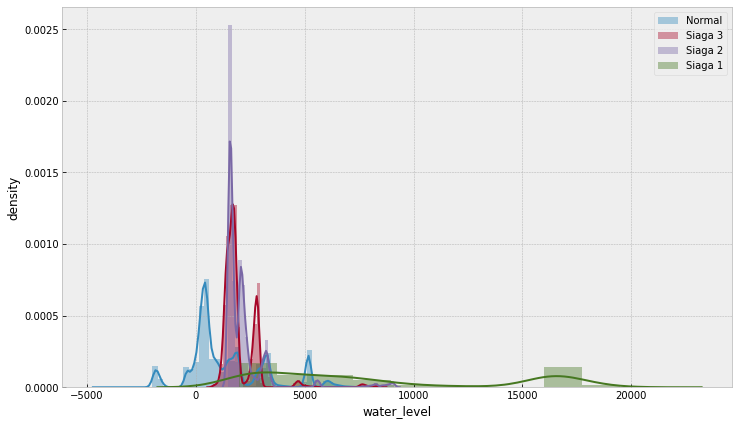

In [10]:
for status in df['status'].unique():
    sns.distplot(df[df['status'] == status].water_level, label=status)
plt.ylabel('density')
plt.legend();

Notice form the previous figure that the distributions are multimodal. Siaga 3 and siaga 2 distributions even overlap each other. To confirm this, let's take a close look.

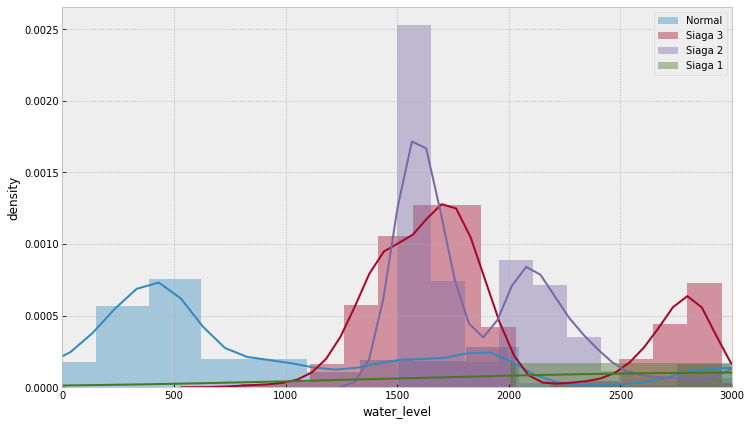

In [11]:
for status in df['status'].unique():
    sns.distplot(df[df['status'] == status].water_level, label=status)
plt.xlim([0,3000])
plt.ylabel('density')
plt.legend();

The histograms suggest that we might see different minimum levels for each sluice gate to reach a particular status.

In [12]:
def show_water_level_per_name(status):
    df[df['status'] == status].groupby('name')['water_level'].plot.hist(alpha=0.5)
    plt.xlabel('water level')
    plt.legend()

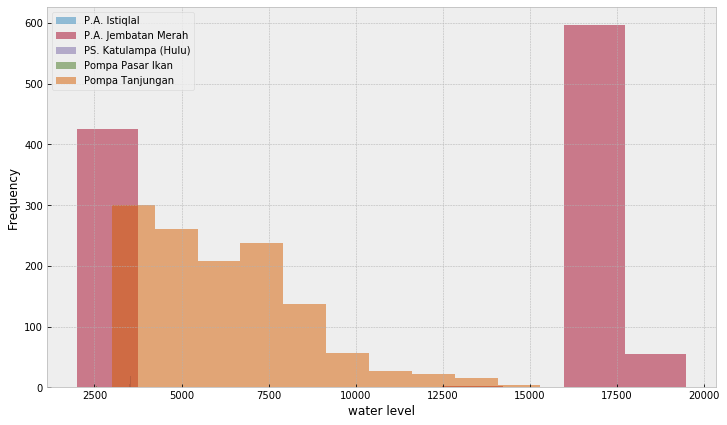

In [13]:
show_water_level_per_name('Siaga 1')

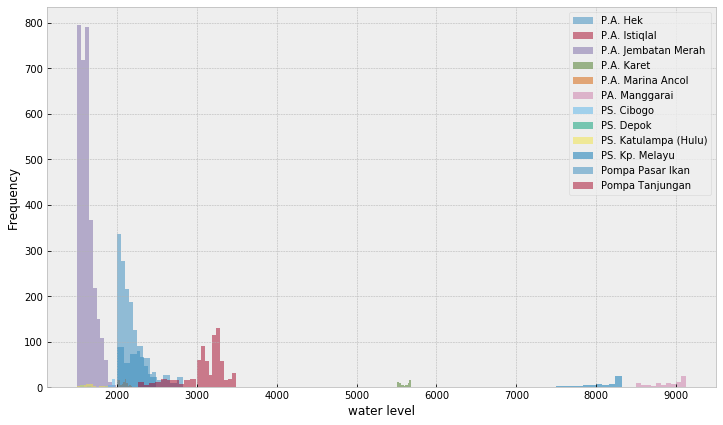

In [14]:
show_water_level_per_name('Siaga 2')

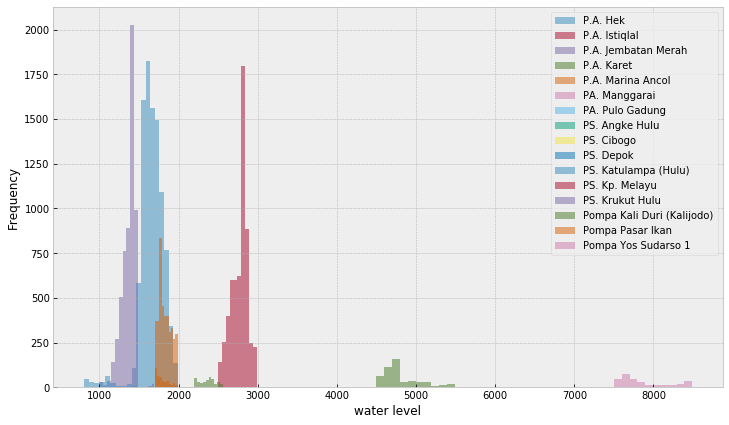

In [15]:
show_water_level_per_name('Siaga 3')

The previous three figures confirm our hypothesis earlier about different water levels. Just so we are more sure about these measurements, we can also see the water levels when it is normal.

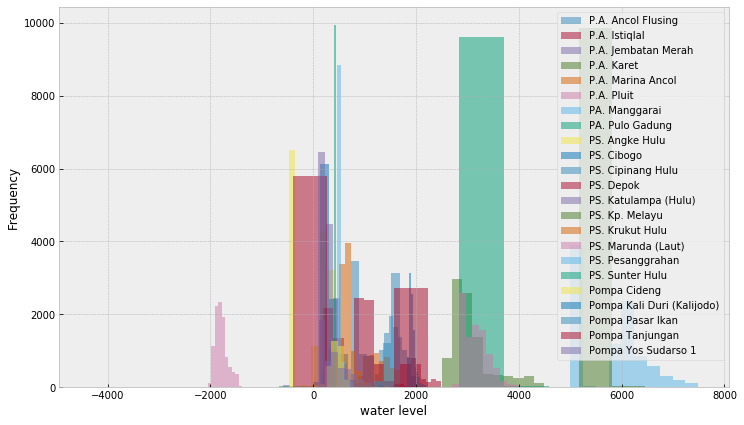

In [16]:
show_water_level_per_name('Normal')

We can also see the minimum, median, and the maximum level of water level for each status of each gate.

In [17]:
df.groupby(['name','status']).agg({'water_level': ['min', 'median', 'max']})

water_level              
                                           min median    max
name                       status                           
P.A. Ancol Flusing         Normal         1200   1560   2090
P.A. Hek                   Siaga 2        2000   2290   2830
                           Siaga 3        1410   1670   1990
P.A. Istiqlal              Normal         1500   1960   2490
                           Siaga 1        3500   3540   3610
                           Siaga 2        3000   3230   3490
                           Siaga 3        2500   2800   2990
P.A. Jembatan Merah        Normal          300    300    830
                           Siaga 1        2000  16210  19470
                           Siaga 2        1500   1600   1990
                           Siaga 3        1000   1400   1490
P.A. Karet                 Normal         2500   2940   4490
                           Siaga 2        5500   5580   5680
                           Siaga 3        4500   4740   5490
P.A. Marina Ancol          Normal          670   1250   1690
                           Siaga 2        2000   2080   2190
                           Siaga 3        1700   1770   1990
P.A. Pluit                 Normal        -2050  -1800  -1380
PA. Manggarai              Normal         5000   5970   7490
                           Siaga 2        8500   8930   9120
                           Siaga 3        7500   7770   8490
PA. Pulo Gadung            Normal        -3300   3280   5460
                           Siaga 3        5510   5600   5600
PS. Angke Hulu             Normal          -40    260   1490
                           Siaga 3        1500   1570   1620
PS. Cibogo                 Normal         -400    290   1380
                           Siaga 2        1540   1980   1980
                           Siaga 3        1420   1440   1490
PS. Cipinang Hulu          Normal            0    830   1490
PS. Depok                  Normal            0    930   1970
                           Siaga 2        2750   2750   2750
                           Siaga 3        2020   2180   2680
PS. Katulampa (Hulu)       Normal         -580    310    790
                           Siaga 1        6550   6550   6550
                           Siaga 2        1500   1645   1890
                           Siaga 3         800   1070   1480
PS. Kp. Melayu             Normal            0   5190   6460
                           Siaga 2        7500   8170   8320
                           Siaga 3        6500   7000   7480
PS. Krukut Hulu            Normal          400    630   1490
                           Siaga 3        1500   1650   1690
PS. Marunda (Laut)         Normal         2700   3130   4030
PS. Pesanggrahan           Normal            0    480    770
PS. Sunter Hulu            Normal            0    450    450
Pompa Cideng               Normal         -470   -380    710
Pompa Kali Duri (Kalijodo) Normal         1830   1910   2190
                           Siaga 3        2200   2380   2560
Pompa Pasar Ikan           Normal            0   1540   1690
                           Siaga 1        2500   2520   2560
                           Siaga 2        2000   2110   2490
                           Siaga 3        1700   1810   1990
Pompa Tanjungan            Normal        -4350   -100   2240
                           Siaga 1        3000   5780  15300
                           Siaga 2        2260   2670   2990
Pompa Yos Sudarso 1        Normal          100    100   1380
                           Siaga 3        1400   1430   1450

Let's take an example. The following figure should show the data from Pompa Pasar Ikan gate.

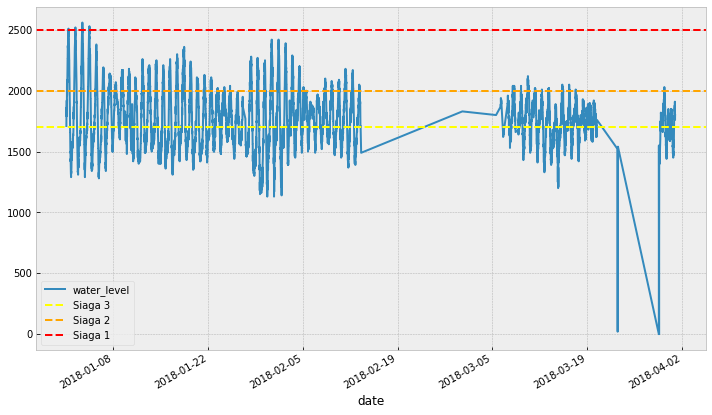

In [18]:
df[df['name'] == 'Pompa Pasar Ikan'].set_index('date').plot.line(y='water_level')
plt.axhline(1700, label='Siaga 3', color='yellow', linestyle='--')
plt.axhline(2000, label='Siaga 2', color='orange', linestyle='--')
plt.axhline(2500, label='Siaga 1', color='red', linestyle='--')
plt.legend();

In [19]:
df[df['name'] == 'Pompa Pasar Ikan']['ds'].value_counts().sort_index()

2018-01-01    137
2018-01-02    143
2018-01-03    143
2018-01-04    143
2018-01-05    144
2018-01-06    143
2018-01-07    142
2018-01-08    144
2018-01-09    143
2018-01-10    144
2018-01-11    144
2018-01-12    142
2018-01-13    144
2018-01-14    143
2018-01-15    144
2018-01-16    145
2018-01-17    143
2018-01-18    144
2018-01-19    134
2018-01-20    142
2018-01-21    145
2018-01-22    144
2018-01-23    143
2018-01-24    142
2018-01-25    144
2018-01-26    141
2018-01-27     89
2018-01-28    145
2018-01-29    144
2018-01-30    149
             ... 
2018-02-05    143
2018-02-06    144
2018-02-07    144
2018-02-08    144
2018-02-09    143
2018-02-10    144
2018-02-11    145
2018-02-12    144
2018-02-13     84
2018-02-28      2
2018-03-05     95
2018-03-06    151
2018-03-07    106
2018-03-08    144
2018-03-09    141
2018-03-10    142
2018-03-11    144
2018-03-12    142
2018-03-13    142
2018-03-14    139
2018-03-15    144
2018-03-16    144
2018-03-17    142
2018-03-18    144
2018-03-19

It shows some missing values from 2018-02-14 until 2018-20-27, only a couple of data points on 2018-02-28, and some more missing values from 2018-03-01 until 2018-03-04 and a handful more at the end of March 2018. We can also see from the data that the water level is decreasing by the end of March.

### Imputing Missing Values

To get a better prediction in the future, we might want to impute those missing values. To do this, we can use Facebook's Prophet library.

In [21]:
from fbprophet import Prophet

data = df[df['name'] == 'Pompa Pasar Ikan'][['date','water_level']].copy()
data['y'] = data['water_level']
data['ds'] = data['date']
data = data[data['ds'].dt.date != '2018-02-28']

In [22]:
ds1 = pd.Series(pd.date_range('2018-02-14 00:00:00', '2018-03-04 23:50:00', freq='10min'), name='ds').reset_index()
ds2 = pd.Series(pd.date_range('2018-03-21 00:00:00', '2018-03-28 23:50:00', freq='10min'), name='ds').reset_index()
ds = pd.concat([ds1, ds2])
ds['y'] = None
ds = ds.drop('index', axis=1)

In [23]:
data = pd.concat([data, ds])
data.loc[data['y'] < 1000, 'y'] = None

In [24]:
m = Prophet(yearly_seasonality=False)
m.fit(data)
imputed = m.predict(data)

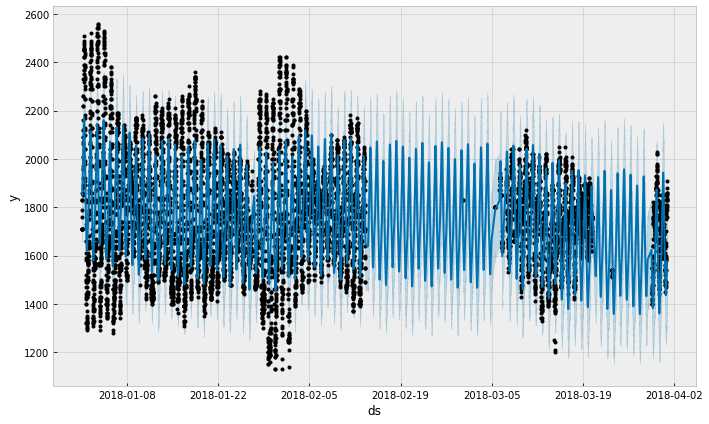

In [25]:
m.plot(imputed);

In [26]:
pv = pd.pivot_table(df, values='water_level', index='ds', columns='name', aggfunc='mean')
pv = pv.fillna(pv.median())

### Embedding

Using dimensionalty reduction (PCA), we can show that nearby gates, which should behave similarly, can be clustered.

In [34]:
gates = df.groupby('name').agg({'location': 'min', 'latitude': 'min', 'longitude': 'min'}).reset_index()

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(pv.T)

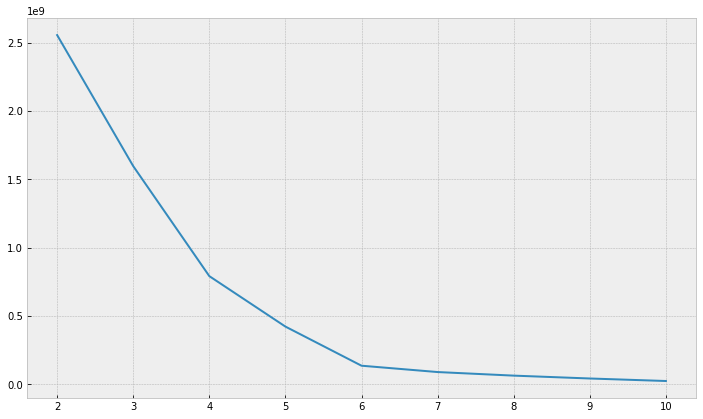

In [41]:
from sklearn.cluster import KMeans

v = []
for k in range(2,11):
    clf = KMeans(k)
    clf.fit(X)
    v.append(clf.inertia_)

plt.plot(range(2,11), v);

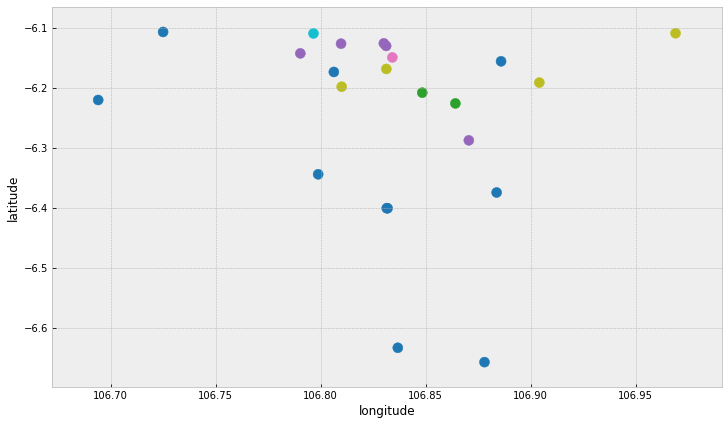

In [43]:
clf = KMeans(6)
clf.fit(X)
plt.scatter(gates['longitude'], gates['latitude'], c=clf.labels_, cmap='tab10', s=100)
plt.xlabel('longitude')
plt.ylabel('latitude');

### Mapping

In [102]:
import folium

m = folium.Map(
    location=[-6.2258816,106.8290876],
    tiles='cartodbpositron',
    zoom_start=10
)

In [104]:
for gate in df['name'].unique():
    row = df[df['name'] == gate].iloc[0]
    if pd.isnull(row['latitude']):
        continue
    folium.Marker(
        location=row[['latitude','longitude']].values,
        popup=gate
    ).add_to(m)

In [105]:
m